# Semantic Search Engine

### This notebook contains an exemple on how to create a semantic search engine for conversational text, ranking the results based on relevance. 

In [1]:
!pip install sentence-transformers
!pip install textblob
!pip install faiss-cpu
!pip install bert-score

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### Import libraries and load base bert model with 512 token limit

In [2]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

### Import dataset

In [3]:
data = pd.read_csv('conversation.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         82 non-null     int64 
 1   text          82 non-null     object
 2   index_column  82 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.0+ KB


In [4]:
data.head()


,index,text,index_column
0,0,"Meeting Chairman: If we are all here, let's ge...",0
1,2,"Jack Peterson: Thank you for having me, I'm lo...",1
2,4,Meeting Chairman: I'd also like to introduce M...,2
3,6,Margaret Simmons: May I also introduce my assi...,3
4,8,Meeting Chairman: Welcome Bob. I'm afraid our ...,4


In [5]:
import gc
df = data[['index_column','text']]
del data
gc.collect()

0

In [6]:
df.head()

,index_column,text
0,0,"Meeting Chairman: If we are all here, let's ge..."
1,1,"Jack Peterson: Thank you for having me, I'm lo..."
2,2,Meeting Chairman: I'd also like to introduce M...
3,3,Margaret Simmons: May I also introduce my assi...
4,4,Meeting Chairman: Welcome Bob. I'm afraid our ...


In [7]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['text'],inplace=True)

### Plot text length distribution

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


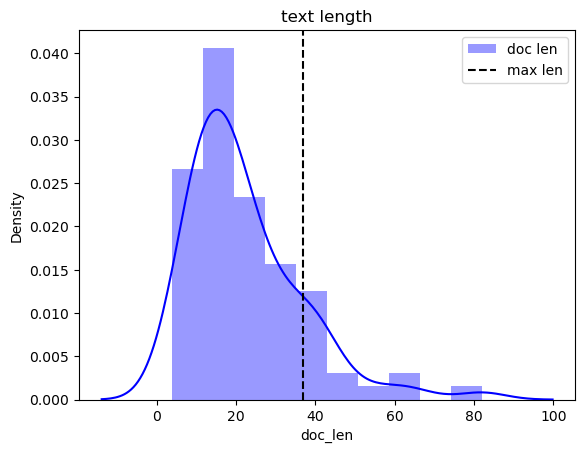

In [8]:
df['doc_len'] = df['text'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('text length'); plt.legend()
plt.show()

# Strategy 1
### The strategy below focus on converting the word embeddings in the dataset without fine tunning the model, generating a search index with faiss

In [9]:
import faiss
encoded_data = model.encode(df.text.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'conversation.index')

In [10]:
def fetch_conversation(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['index_column'] = info['index_column']
    meta_dict['text'] = info['text'][:500]
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_conversation(idx) for idx in top_k_ids]
    return results

In [11]:
from pprint import pprint

query="major holiday"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.015205621719360352


	 {'index_column': 26, 'text': "Meeting Chairman: Thank you very much Jack. Right, it looks as though we've covered the main items Is there any other business?"}
	 {'index_column': 28, 'text': "Meeting Chairman: Good idea Donald. How does Friday in two weeks time sound to everyone? Let's meet at the same time, 9 o'clock. Is that OK for everyone? Excellent. I'd like to thank Jack for coming to our meeting today. The meeting is closed."}
	 {'index_column': 39, 'text': "Tom: Let's see whether I will have any free time next month. I know sometime next month I will have to go to Texas on a business trip."}
	 {'index_column': 49, 'text': 'Tom: I hate those types of days. Luckily, it is not that bad in our company. Besides, we are in the process of updating our computer system, and we can use this slow period to finish the process. '}
	 {'index_column': 66, 'text': 'Jane: I think you should put a call in to Trucking Lines as soon as possible.

# Strategy 2
### Fine tunes the model using the conversation dataset with synthetic generated queries using the query-gen-msmarco-t5-large-v1 t5 model.
### One of the advantages of Strategy 2, compared with Strategy 1, is that by generating syntetic queries as examples the model is much more capable of understanding similar expressions within the context of the dataset.

### Disclaimer
#### The current synthetic query generation technique is not yielding good results probably because the dataset was not pre processed correctly. However, this is just a POC done in a 2-3 hours so I could not spend a good deal of time pre processing the dataset. 

#### Creates paragraphs for conversations

In [12]:
paragraphs=df.text.tolist()

#### Imports t5 model

In [13]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [14]:
#Select the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [15]:
# Parameters for generation
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query

In [16]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

#### Generates the syntetic queries to fine tune bert

In [17]:
def generate_synthetic_queries():
    with open('generated_queries_all.csv', 'w') as fOut:
        for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
            sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
            inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
            outputs = model.generate(
                **inputs,
                max_length=max_length_query,
                do_sample=True,
                top_p=0.95,
                num_return_sequences=num_queries)

            for idx, out in enumerate(outputs):
                query = tokenizer.decode(out, skip_special_tokens=True)
                query = _removeNonAscii(query)
                para = sub_paragraphs[int(idx/num_queries)]
                para = _removeNonAscii(para)
                fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

In [18]:
generate_synthetic_queries()

  0%|          | 0/6 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3707: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
100%|██████████| 6/6 [01:19<00:00, 13.31s/it]


#### Fine tunes Bert with the synthetic  queries

In [34]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('generated_queries_all.csv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

#### Saves fine tuned the Bert model

In [35]:
from sentence_transformers import SentenceTransformer, util
import gzip
import json
import os

model = SentenceTransformer('search/search-model')

In [36]:
!zip -r search_model.zip "./search"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
updating: search/ (stored 0%)
updating: search/search-model/ (stored 0%)
updating: search/search-model/pytorch_model.bin (deflated 8%)
updating: search/search-model/tokenizer_config.json (deflated 44%)
updating: search/search-model/modules.json (deflated 53%)
updating: search/search-model/config_sentence_transformers.json (deflated 27%)
updating: search/search-model/sentence_bert_config.json (deflated 4%)
updating: search/search-model/README.md (deflated 58%)
updating: search/search-model/1_Pooling/ (stored 0%)
updating: search/search-model/1_Pooling/config.json (deflated 47%)
updating: search/search-model/vocab.txt (deflated 53%)
updating: search/search-model/tokeniz

#### Creates a new index file by creating word embeddings using the fine tuned model

In [37]:
import faiss
encoded_data = model.encode(df.text.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'conversation-tuned.index')

In [38]:
from pprint import pprint

query="major holiday"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.020527362823486328


	 {'index_column': 28, 'text': "Meeting Chairman: Good idea Donald. How does Friday in two weeks time sound to everyone? Let's meet at the same time, 9 o'clock. Is that OK for everyone? Excellent. I'd like to thank Jack for coming to our meeting today. The meeting is closed."}
	 {'index_column': 38, 'text': 'Ana: You need to sign up for the Learn How To Delegate seminar. It is coming next month.'}
	 {'index_column': 39, 'text': "Tom: Let's see whether I will have any free time next month. I know sometime next month I will have to go to Texas on a business trip."}
	 {'index_column': 50, 'text': 'Ana: Good for you. Oh, 10:30 AM already. I guess our break-time is over. '}
	 {'index_column': 66, 'text': 'Jane: I think you should put a call in to Trucking Lines as soon as possible. The thirtieth of this month is a major holiday, and its shipping schedule is going to be very tight.'}


# Ranking Results

## Re-Ranker: Cross-Encoder

The retriever has to be efficient for large document collections with millions of entries. However, it might return irrelevant candidates.

A re-ranker based on a Cross-Encoder can substantially improve the final results for the user. The query and a possible document is passed simultaneously to transformer network, which then outputs a single score between 0 and 1 indicating how relevant the document is for the given query.

The advantage of Cross-Encoders is the higher performance, as they perform attention across the query and the document.

Scoring thousands or millions of (query, document)-pairs would be rather slow. Hence, we use the retriever to create a set of e.g. 100 possible candidates which are then re-ranked by the Cross-Encoder.

In [39]:
from sentence_transformers import CrossEncoder
cross_model = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-6', max_length=512)

In [40]:
def cross_score(model_inputs):
    scores = cross_model.predict(model_inputs)
    return scores

model_inputs = [[query,item['text']] for item in results]
scores = cross_score(model_inputs)
#Sort the scores in decreasing order
ranked_results = [{'index_column': inp['index_column'], 'Score': score} for inp, score in zip(results, scores)]
ranked_results = sorted(ranked_results, key=lambda x: x['Score'], reverse=True)


In [41]:
print("\n")
for result in ranked_results:
    print('\t',pprint(result))



{'Score': 0.05740165, 'index_column': 66}
	 None
{'Score': 0.00019354839, 'index_column': 38}
	 None
{'Score': 0.00018959517, 'index_column': 50}
	 None
{'Score': 0.00016893119, 'index_column': 39}
	 None
{'Score': 0.00016891235, 'index_column': 28}
	 None


## Ranking with Bert Score

In [42]:
import bert_score
bert_score.__version__

'0.3.12'

In [43]:
from bert_score import score

In [44]:
ref=["major holiday"]

In [45]:
ranked_results_bert = []

for cand in results:
    P, R, F1 = score([cand['text']], ref, lang='en')
    ranked_results_bert.append({'index_column': cand['index_column'], 'Score': F1.numpy()[0]})

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaM

In [46]:
ranked_results_bert = sorted(ranked_results_bert, key=lambda x: x['Score'], reverse=True)
print("\n")
for result in ranked_results_bert:
    print('\t',pprint(result))



{'Score': 0.83098245, 'index_column': 66}
	 None
{'Score': 0.8176308, 'index_column': 50}
	 None
{'Score': 0.81755286, 'index_column': 39}
	 None
{'Score': 0.8169827, 'index_column': 38}
	 None
{'Score': 0.80081874, 'index_column': 28}
	 None


## Comparing Results

In [47]:
final_results = pd.DataFrame()
final_results['faiss_ranking'] = [item['index_column'] for item in results]
final_results['cross_encoder'] = [item['index_column'] for item in ranked_results]
final_results['bert_score'] = [item['index_column'] for item in ranked_results_bert]


In [48]:
final_results.head()

,faiss_ranking,cross_encoder,bert_score
0,28,66,66
1,38,38,50
2,39,50,39
3,50,39,38
4,66,28,28
